Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras

## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

In [4]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences


In [ ]:
x_train[0]

In [6]:
print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [4]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

### First Run, with maxlen = 80, batch_size = 32

In [15]:
model = Sequential()

model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [16]:
unicorns = model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=5, 
          validation_data=(x_test,y_test))


Epoch 1/5
782/782 [==============================] - 271s 346ms/step - loss: 0.4353 - accuracy: 0.7964 - val_loss: 0.3921 - val_accuracy: 0.8255
Epoch 2/5
292/782 [==========>...................] - ETA: 2:38 - loss: 0.2504 - accuracy: 0.8987

KeyboardInterrupt: ignored

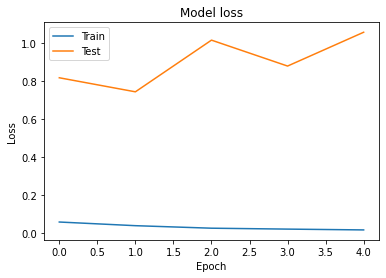

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

### Second Run, with maxlen = 80, batch_size = 32

In [11]:
# Tweaked
import tensorflow as tf

adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

model2 = Sequential()

model2.add(Embedding(max_features, 64))
model2.add(LSTM(64))
model2.add(Dense(64))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,317,249
Trainable params: 1,317,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
unicorns2 = model2.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=5, 
          validation_data=(x_test,y_test))


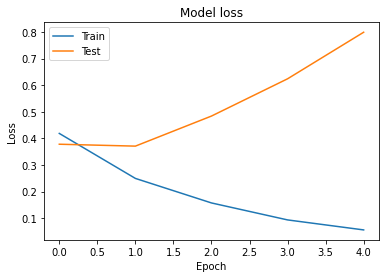

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns2.history['loss'])
plt.plot(unicorns2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

### Third run with maxlen= 120, batch_size to 64

In [13]:
max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 120
batch_size = 64

In [17]:
print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 120)
x_test shape:  (25000, 120)


In [18]:
# Tweaked
import tensorflow as tf

adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

model3 = Sequential()

model3.add(Embedding(max_features, 64))
model3.add(LSTM(64))
model3.add(Dense(64))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,317,249
Trainable params: 1,317,249
Non-trainable params: 0
_________________________________________________________________


In [19]:
unicorns3 = model3.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=5, 
          validation_data=(x_test,y_test))


Epoch 1/5
391/391 [==============================] - 10s 27ms/step - loss: 0.4269 - accuracy: 0.7953 - val_loss: 0.3507 - val_accuracy: 0.8435
Epoch 2/5
391/391 [==============================] - 10s 25ms/step - loss: 0.2399 - accuracy: 0.9034 - val_loss: 0.3913 - val_accuracy: 0.8313
Epoch 3/5
391/391 [==============================] - 10s 25ms/step - loss: 0.1434 - accuracy: 0.9458 - val_loss: 0.4932 - val_accuracy: 0.8247
Epoch 4/5
391/391 [==============================] - 9s 24ms/step - loss: 0.0865 - accuracy: 0.9681 - val_loss: 0.7199 - val_accuracy: 0.8185
Epoch 5/5
391/391 [==============================] - 9s 24ms/step - loss: 0.0531 - accuracy: 0.9811 - val_loss: 0.9272 - val_accuracy: 0.8102


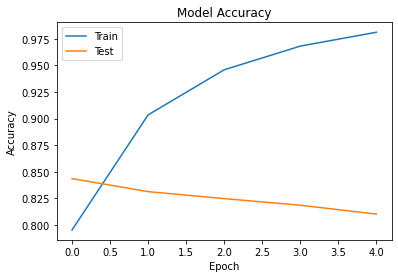

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns3.history['accuracy'])
plt.plot(unicorns3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

### Last *Tweak*, lowered lr, added bidirectional layer

In [26]:
# Tweaked
import tensorflow as tf

adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model4 = Sequential()

model4.add(Embedding(max_features, 64))
model4.add(tf.keras.layers.Bidirectional(LSTM(64)))
model4.add(Dense(64))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model4.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,354,369
Trainable params: 1,354,369
Non-trainable params: 0
_________________________________________________________________


In [27]:
unicorns4 = model4.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=5, 
          validation_data=(x_test,y_test))

Epoch 1/5
391/391 [==============================] - 13s 32ms/step - loss: 0.4480 - accuracy: 0.7813 - val_loss: 0.3713 - val_accuracy: 0.8343
Epoch 2/5
391/391 [==============================] - 12s 30ms/step - loss: 0.2446 - accuracy: 0.9009 - val_loss: 0.3736 - val_accuracy: 0.8345
Epoch 3/5
391/391 [==============================] - 12s 30ms/step - loss: 0.1515 - accuracy: 0.9425 - val_loss: 0.4465 - val_accuracy: 0.8249
Epoch 4/5
391/391 [==============================] - 12s 30ms/step - loss: 0.0908 - accuracy: 0.9673 - val_loss: 0.6454 - val_accuracy: 0.8212
Epoch 5/5
391/391 [==============================] - 12s 30ms/step - loss: 0.0553 - accuracy: 0.9802 - val_loss: 0.6576 - val_accuracy: 0.8097


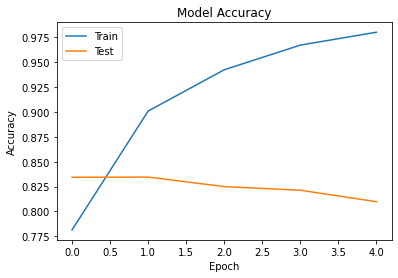

In [28]:
# Plot training & validation loss values
plt.plot(unicorns4.history['accuracy'])
plt.plot(unicorns4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [26]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf
import numpy as np
import random
import sys
import os

In [7]:
#data_files = os.listdir('./articles')

In [27]:
import pandas as pd

url = "https://raw.githubusercontent.com/JenBanks8585/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/wp_articles.json"

df = pd.read_json(url)
df.head()

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."


In [6]:
# Read in Data, this cell needed if reading from jupyter lab where json is available

#data = []

#for file in data_files:
#    if file[-3:] == 'txt':
#        with open(f'./articles/{file}', 'r', encoding='utf-8') as f:
#            data.append(f.read())

In [28]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later
text = " ".join(df['article'].values)

# Unique Characters
chars = list(set(text))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [29]:
len(chars)

121

In [30]:
# Create the sequence data

maxlen = 40  # 40 charcaters
step = 5      # choose 40, then step 5, choose another set of 40, step 5 choose set of 40 again

encoded = [char_int[c] for c in text]

sequences = [] # Each element is 40 chars long
next_char = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sequences.append(encoded[i : i + maxlen])
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences))


sequences:  178374


In [31]:
len(sequences[0])

40

In [32]:
# Create x & y

x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i,t,char] = 1
        
    y[i, next_char[i]] = 1
        

In [33]:
x.shape

(178374, 40, 121)

In [34]:
y.shape

(178374, 121)

In [35]:
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [37]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
# fit the model

model.fit(x, y,
          batch_size=32,
          epochs=10,
          callbacks=[print_callback])

Epoch 1/10
   1/5575 [..............................] - ETA: 14s - loss: 2.7105WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0348s). Check your callbacks.


5575/5575 [==============================] - ETA: 0s - loss: 2.1315
----- Generating text after Epoch: 0
----- Generating with seed: " and anti-media rhetoric.

“This video i"
 and anti-media rhetoric.

“This video insakalys ba ie lile is fiach.

Senantss yon derasion of nis chemaing wad than 1whing the ingestre and Hmeth-peest’s ouning piversn Salices Dolicy youre Righ, Hore the Sindars to comical iorhoried be usen, wander conally" sice shome ovarsheadic, mect-amper bist deyiouch werchiantedors ow the sore mutes sove tom Lek. Reppermaid.

The haschad thand weires (SVas orvened ind in your ophourde Amatio Ama
5575/5575 [==============================] - 198s 36ms/step - loss: 2.1315
Epoch 2/10
5574/5575 [============================>.] - ETA: 0s - loss: 2.0530
----- Generating text after Epoch: 1
----- Generating with seed: ", 1969, accompanied by astronaut Neil Ar"
, 1969, accompanied by astronaut Neil Arerlirg for Purpann the ruppended in Washia a lit to rearr song oftar-opably with 

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

* Create a Tensorflow Dataset
* Attempt to use exponential TPUs from Colab


In [39]:
data = tf.data.Dataset.from_tensor_slices(x)
target = tf.data.Dataset.from_tensor_slices(y)

dataset= tf.data.Dataset.zip((data, target))

In [40]:
dataset

<ZipDataset shapes: ((40, 121), (121,)), types: (tf.bool, tf.bool)>

In [41]:
batched_Dataset= dataset.batch(256, drop_remainder=True)

In [42]:
try:
  device_name = os.environ["COLAB_TPU_ADDR"]
  TPU_ADDRESS = "qrpc://" + device_name
  print("Found TPU at : {}".format(TPU_ADDRESS))
except KeyError:
  print("TPU not found")

Found TPU at : qrpc://10.102.242.178:8470


In [43]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.102.242.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.102.242.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]


In [45]:
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

model.fit(batched_Dataset,
          steps_per_epoch = x.shape[0]//256,
          epochs=10,
          callbacks=[print_callback])



Epoch 1/10
  2/696 [..............................] - ETA: 32s - loss: 4.7907WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_train_batch_end` time: 0.0908s). Check your callbacks.


696/696 [==============================] - ETA: 0s - loss: 3.0103
----- Generating text after Epoch: 0
----- Generating with seed: "strategy for thinking of out-of-the-box "
strategy for thinking of out-of-the-box loud 
tes tar ay iumorMtofri Bleronitene fbeit. aver 0usit., de Gfev ;aritod Te aeistlit’ led —os. iird e2 Ariaf ader.Ly bs th loslse deo ndiy oales thme.y ryalrt nyeeve ,ad,, iagdlebH ad ph0sp a- thsinei. le an’taRoogfehaui tcdryhI jhowe hoans’ aetinus orls-destmyr niy beliwe 0eveegp oolin dosl ?amo a onndee simiantrccereantasthaagf vacloi roMulale the moot anN anctuosRr ormeonrTekad the shiuf 7a
696/696 [==============================] - 88s 127ms/step - loss: 3.0103
Epoch 2/10
696/696 [==============================] - ETA: 0s - loss: 2.6019
----- Generating text after Epoch: 1
----- Generating with seed: "order between these two countries now st"
order between these two countries now ster of ping ondiid it l andokse yeidid roSraresl2 one fer hile anlasc ar ore sart anlale

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 